In [42]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [43]:
from architectures.architectures import MLP

from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [44]:
index = 3
device = jax.devices()[index] if jax.devices() else jax.devices('cpu')[0] # If only one gpu change index to 0
print(f"Selected device: {device}")

Selected device: cuda:3


# Import model

In [4]:
model = MLP(din=1, num_layers=3, width_layers=64, dout=1, activation_fn="SinTu", rngs=nnx.Rngs(0))

In [5]:
y = model(x = jnp.ones((10,1),device= device))

# NODE setup

In [45]:
from architectures.node import NeuralODE

In [46]:
key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)
model = MLP(din=2, num_layers=3, width_layers=128, dout=2, activation_fn="tanh", rngs=nnx.Rngs(0))
node = NeuralODE(
    dynamics_model=model,
    time_dependent=False,
    dt0=0.1,
    rtol=1e-4,
    atol=1e-6
)

# Initial condition
y0 = jnp.array([1.0, 0.5])

# Solve from t=0 to t=1
y_final = node(y0, (0.0, 1.0))
print("Final state:", y_final)

Final state: [[0.95567995 0.4358569 ]]


# G Mat

In [47]:
from geometry.G_matrix import G_matrix

In [48]:
G_mat = G_matrix(node)

In [50]:
# Test
key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)

n_samples = 100_000
d = 2
z_samples = jax.random.normal(key,(n_samples,d))

z_samples = jax.device_put(z_samples,device)


In [51]:
_,params = nnx.split(node)
key,subkey = jax.random.split(key)
eta = jax.tree.map(lambda p:jax.random.normal(subkey, p.shape)*10, params) #   jax.numpy.ones(p.shape)
eta = jax.tree.map(lambda p: jax.device_put(p,device), eta)
key,subkey = jax.random.split(key)
epsilon = jax.tree.map(lambda p: jax.random.normal(subkey, p.shape)*0.1, params)
eta_pert = jax.tree.map(lambda e,ep: e+ep, eta, epsilon)

In [52]:
# Compute G_hat@eta
result = G_mat.mvp(z_samples, eta)

In [60]:
key,subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey,(n_samples,d))
z_samples = jax.device_put(z_samples,device)

# Test solver 
result_solver, _ = G_mat.solve_system(z_samples, result, tol=1e-6, maxiter=20,x0 = eta_pert, method="minres")

{'success': False, 'iterations': 20, 'norm_res': Array(0.00853094, dtype=float32)}


In [61]:
jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result_solver, eta)

State({
  'dynamics': {
    'layers': {
      0: {
        'bias': VariableState( # 1 (4 B)
          type=Param,
          value=Array(0.04471598, dtype=float32)
        ),
        'kernel': VariableState( # 1 (4 B)
          type=Param,
          value=Array(0.02479984, dtype=float32)
        )
      },
      2: {
        'bias': VariableState( # 1 (4 B)
          type=Param,
          value=Array(0.03657987, dtype=float32)
        ),
        'kernel': VariableState( # 1 (4 B)
          type=Param,
          value=Array(0.01047239, dtype=float32)
        )
      },
      4: {
        'bias': VariableState( # 1 (4 B)
          type=Param,
          value=Array(0.02388834, dtype=float32)
        ),
        'kernel': VariableState( # 1 (4 B)
          type=Param,
          value=Array(0.01018232, dtype=float32)
        )
      },
      6: {
        'bias': VariableState( # 1 (4 B)
          type=Param,
          value=Array(0.0788613, dtype=float32)
        ),
        'kernel': Variable

In [62]:
verify_result = G_mat.mvp(z_samples, result_solver)
jax.tree.leaves(jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result, verify_result))

[Array(6.637589e-05, dtype=float32),
 Array(0.00091367, dtype=float32),
 Array(6.064916e-05, dtype=float32),
 Array(0.00083523, dtype=float32),
 Array(3.8540686e-05, dtype=float32),
 Array(0.00087112, dtype=float32),
 Array(2.2415923e-05, dtype=float32),
 Array(0.00085434, dtype=float32)]

# Gradient flow test

In [63]:
@jax.jit
def quadratic_potential(x: Array) -> Array:
    """
    Evaluate quadratic potential U(x) = x^2 (sum over dimensions)
    Args:
        x: Array of shape (batch_size, d) - particle positions
    Returns:
        Array of shape (batch_size,) - potential values
    """
    return jnp.sum(x**2, axis=-1)


In [64]:
from typing import Optional
from jaxtyping import PyTree,Array
from flax import nnx
import jax

In [27]:
def compute_energy_gradient(node: nnx.Module, z_samples: Array, params: Optional[PyTree] = None) -> PyTree:
    """
    Compute gradient of energy functional F(ρ) = ∫ U(x)ρ(x)dx
    Args:
        node: Neural ODE model
        z_samples: Reference samples (batch_size, d)
        params: Parameters to evaluate gradient at (if None, uses current node params)
    Returns:
        Gradient ∇_θ F(θ)
    """
    if params is None:
        _, params = nnx.split(node)
    
    def energy_functional(p: PyTree) -> Array:
        # Transform reference samples through flow
        x_samples = node(z_samples, (0.0, 1.0), params=p)
        # Evaluate potential and average (Monte Carlo estimate)
        potential_values = quadratic_potential(x_samples)
        return jnp.mean(potential_values)
    
    return jax.grad(energy_functional)(params)

In [65]:
def evaluate_energy(node: nnx.Module, z_samples: Array, params: Optional[PyTree] = None) -> Array:
    """
    Evaluate current energy F(ρ_θ)
    Args:
        node: Neural ODE model
        z_samples: Reference samples
        params: Parameters (if None, uses current node params)
    Returns:
        Energy value
    """
    if params is None:
        _, params = nnx.split(node)

    x_samples = node(z_samples, (0.0, 1.0), params=params)
    potential_values = quadratic_potential(x_samples)
    return jnp.mean(potential_values),x_samples

In [96]:
# Cell 2: Initial Setup and Configuration

# Gradient flow parameters
h = .5  # Time step size
max_iterations = 20
tolerance = 1e-6
n_samples = 50_000  # Monte Carlo sample size

# Initialize NODE with small parameters (near-identity pushforward)
key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)

# Create NODE model
gradient_flow_model = MLP(din=2, num_layers=3, width_layers=64, dout=2, 
                         activation_fn="tanh", rngs=rngs)
gradient_flow_node = NeuralODE(
    dynamics_model=gradient_flow_model,
    time_dependent=False,
    dt0=0.1,
    rtol=1e-4,
    atol=1e-6
)

# Set parameters to be very small (near zero)
_, initial_params = nnx.split(gradient_flow_node)
scale_factor = 0  # Small scaling to keep near identity

# Scale all parameters to be small
small_params = jax.tree.map(lambda p: p * scale_factor, initial_params)

# Merge back into the node
graphdef, _ = nnx.split(gradient_flow_node)
gradient_flow_node = nnx.merge(graphdef, small_params)

# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

# Initialize tracking arrays
energy_history = []
solver_stats = []
param_norms = []

print(f"Initial setup complete:")
print(f"- Time step: {h}")
print(f"- Max iterations: {max_iterations}")
print(f"- Sample size: {n_samples}")
print(f"- Parameter scale factor: {scale_factor}")

# Verify initial energy (should be ~1.0 since E[x^2] for N(0,I) in 2D is 2.0)
_, current_params = nnx.split(gradient_flow_node)
initial_energy,push_samples = evaluate_energy(gradient_flow_node, z_samples, current_params)
print(f"- Initial energy: {initial_energy:.6f}")

energy_history.append(initial_energy)

Initial setup complete:
- Time step: 0.5
- Max iterations: 20
- Sample size: 50000
- Parameter scale factor: 0
- Initial energy: 1.990477


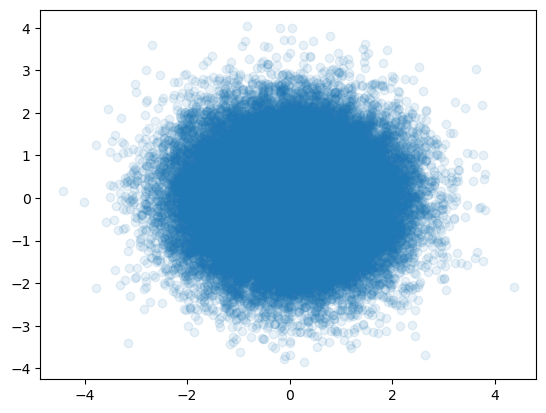

In [97]:
import matplotlib.pyplot as plt

plt.scatter(push_samples[:,0], push_samples[:,1], alpha=0.1)

In [98]:

def gradient_flow_step(node: nnx.Module, z_samples: Array, G_mat: G_matrix, 
                      step_size: float = 0.01, solver_tol: float = 1e-6, 
                      solver_maxiter: int = 50) -> tuple[nnx.Module, dict]:
    """
    Perform one gradient flow step: θ^{k+1} = θ^k + h * η
    where G(θ^k) η = -∇_θ F(θ^k)
    
    Args:
        node: Current Neural ODE model
        z_samples: Reference samples for Monte Carlo estimation
        G_mat: G-matrix object for linear system solving
        step_size: Gradient flow step size h
        solver_tol: Tolerance for G-matrix linear solver
        solver_maxiter: Maximum iterations for linear solver
        
    Returns:
        updated_node: Node with updated parameters
        step_info: Dictionary with step diagnostics
    """
    
    # Get current parameters
    _, current_params = nnx.split(node)
    
    # Compute energy gradient ∇_θ F(θ)
    energy_grad = compute_energy_gradient(node, z_samples, current_params)
    
    # Solve linear system: G(θ) η = -∇_θ F(θ)
    neg_energy_grad = jax.tree.map(lambda x: -x, energy_grad)
    eta, solver_info = G_mat.solve_system(z_samples, neg_energy_grad, 
                                         params=current_params,
                                         tol=solver_tol, 
                                         maxiter=solver_maxiter,
                                         method="cg")
    
    # Update parameters: θ^{k+1} = θ^k + h * η
    updated_params = jax.tree.map(lambda p, e: p + step_size * e, current_params, eta)
    
    # Create updated node
    graphdef, _ = nnx.split(node)
    updated_node = nnx.merge(graphdef, updated_params)
    
    # Compute diagnostics
    grad_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), energy_grad))))
    eta_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), eta))))
    param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), updated_params))))
    
    step_info = {
        # 'solver_success': solver_info['success'],
        # 'solver_iterations': solver_info['iterations'],
        # 'solver_residual': solver_info['norm_res'],
        'gradient_norm': grad_norm,
        'eta_norm': eta_norm,
        'param_norm': param_norm,
        'step_size': step_size
    }
    
    return updated_node, step_info

# Initialize G-matrix for gradient flow
G_mat_flow = G_matrix(gradient_flow_node)



In [99]:

print("Testing single gradient flow step...")

# Store initial state
_, initial_params = nnx.split(gradient_flow_node)
initial_energy,initial_samples = evaluate_energy(gradient_flow_node, z_samples, initial_params)

# Perform one gradient flow step
updated_node, step_info = gradient_flow_step(gradient_flow_node, z_samples, G_mat_flow, 
                                           step_size=h, solver_tol=tolerance)

# Compute energy after step
_, updated_params = nnx.split(updated_node)
final_energy,final_samples = evaluate_energy(updated_node, z_samples, updated_params)

# Verification checks
energy_decrease = initial_energy - final_energy
relative_decrease = energy_decrease / initial_energy

print(f"\n=== Step Verification Results ===")
print(f"Initial energy:     {initial_energy:.6f}")
print(f"Final energy:       {final_energy:.6f}")
print(f"Energy decrease:    {energy_decrease:.6f}")
print(f"Relative decrease:  {relative_decrease:.4%}")
# print(f"Solver success:     {step_info['solver_success']}")
# print(f"Solver iterations:  {step_info['solver_iterations']}")
# print(f"Solver residual:    {step_info['solver_residual']:.2e}")
print(f"Gradient norm:      {step_info['gradient_norm']:.6f}")
print(f"Update norm:        {step_info['eta_norm']:.6f}")

# Validation
assert energy_decrease > 0, f"Energy should decrease! Got decrease: {energy_decrease}"
# assert step_info['solver_success'], "Linear solver should converge!"
# assert step_info['solver_residual'] < tolerance * 10, "Solver residual too large!"

print(f"\n✓ All checks passed! Gradient flow step working correctly.")

Testing single gradient flow step...

=== Step Verification Results ===
Initial energy:     1.990477
Final energy:       1.990396
Energy decrease:    0.000081
Relative decrease:  0.0041%
Gradient norm:      0.016217
Update norm:        0.020022

✓ All checks passed! Gradient flow step working correctly.


Text(0.5, 1.0, 'Final Samples')

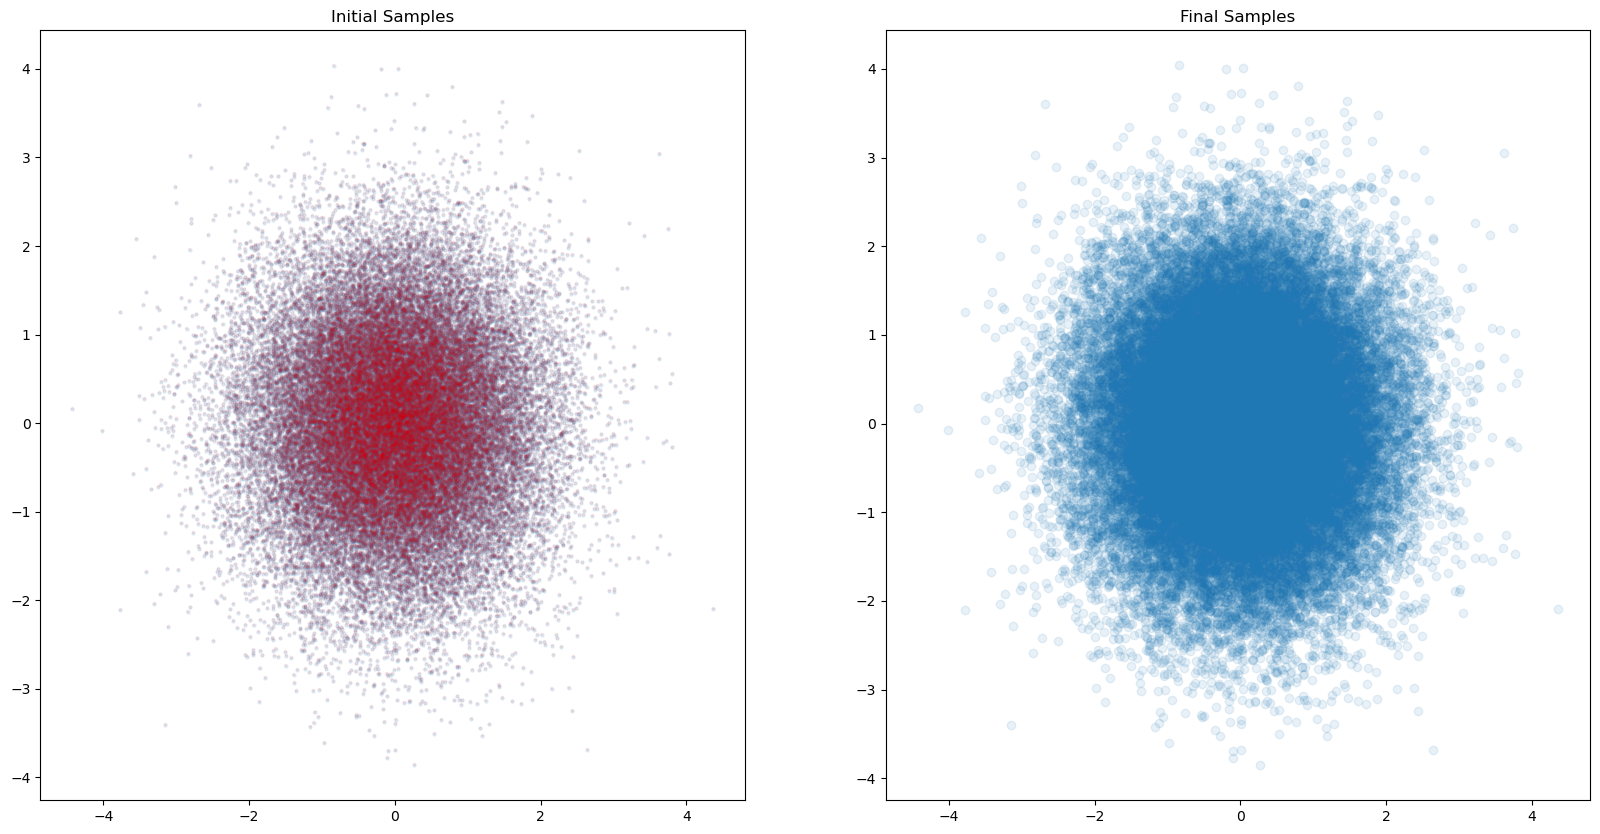

In [100]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(initial_samples[:,0],initial_samples[:,1], s = 5, alpha=0.1)
ax[0].scatter(final_samples[:,0],final_samples[:,1], alpha=0.05 ,s = 3,c  = 'r')
ax[0].set_title("Initial Samples")
ax[1].scatter(final_samples[:,0],final_samples[:,1], alpha=0.1)
ax[1].set_title("Final Samples")

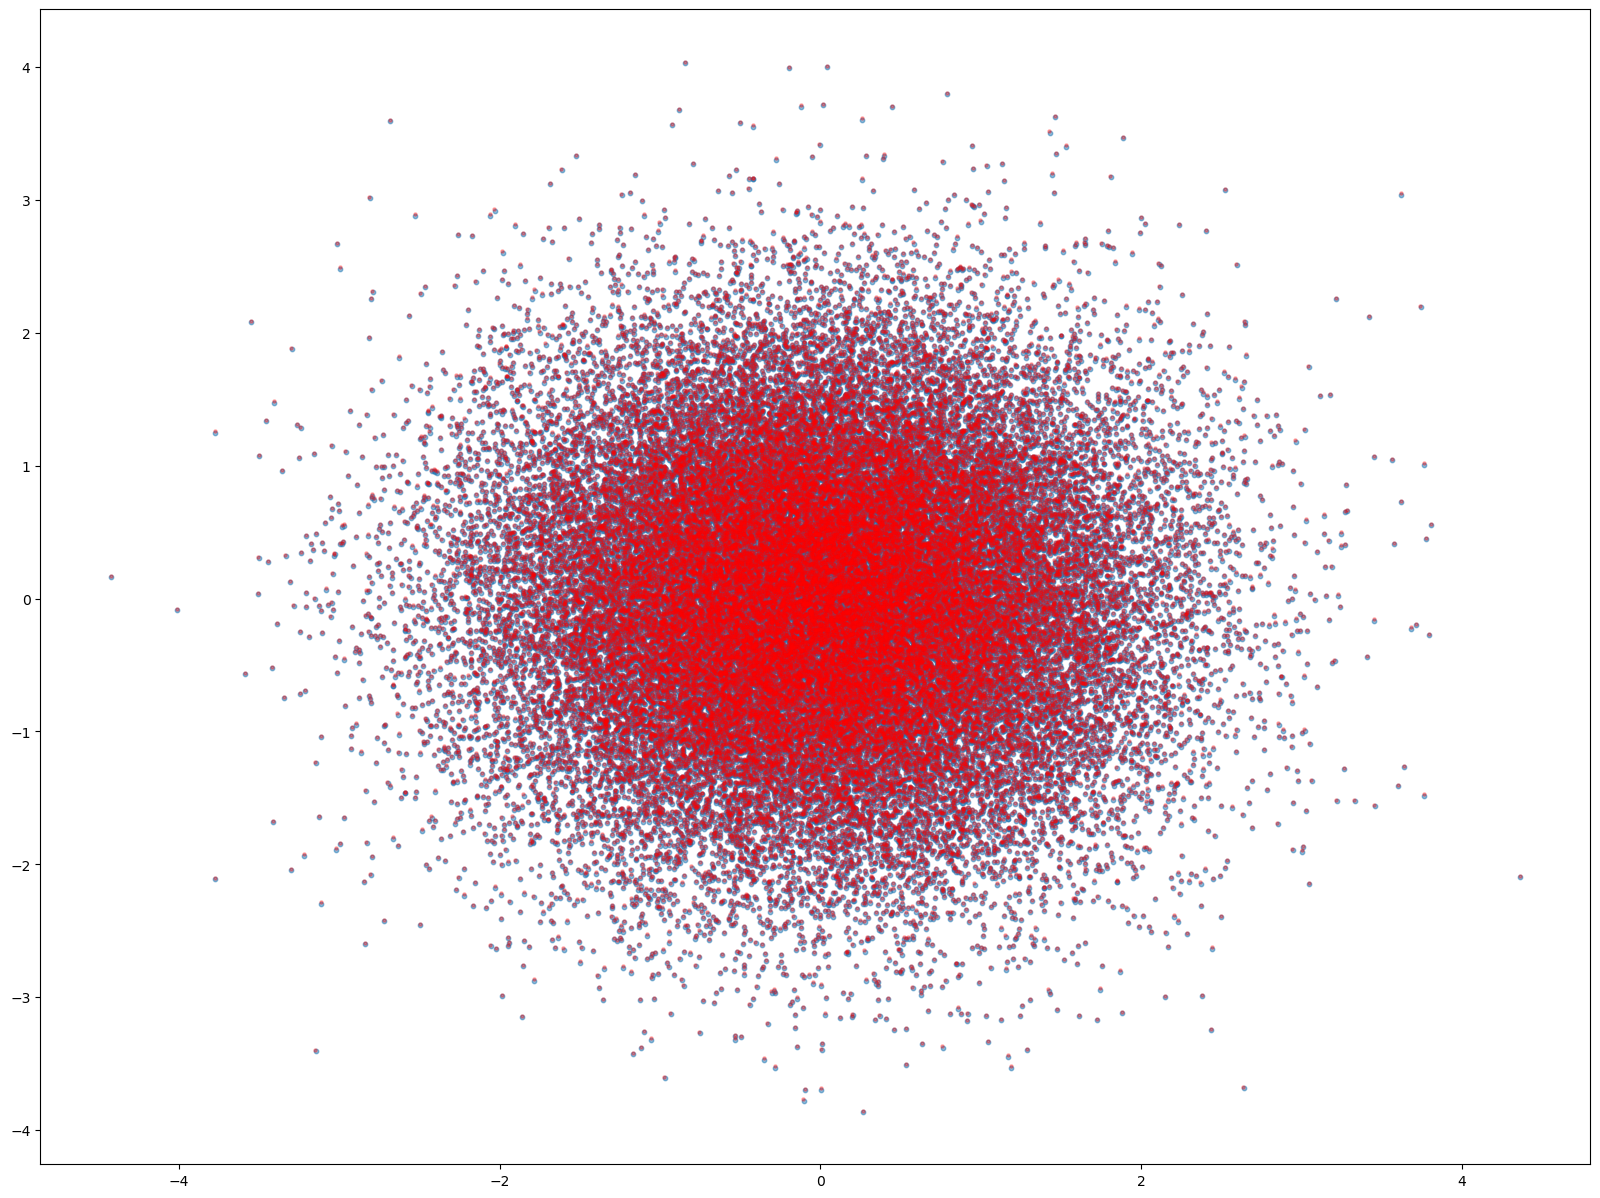

In [104]:
fig = plt.figure(figsize=(20,15))
plt.scatter(initial_samples[:,0],initial_samples[:,1], alpha=0.5,s = 10)
plt.scatter(final_samples[:,0],final_samples[:,1], alpha=0.3,s = 5, c = 'r')